In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from tqdm.autonotebook import tqdm
import os
import cftime
import json
from dask import array
# import statsmodels.api as sm
from scipy.optimize import curve_fit

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

dfs = pd.DataFrame(name.split('_')[0:3] + [name.split('_')[3].replace('.npy','')] + ['pangeo_data/'+name] for name in os.listdir('pangeo_data') if name[0] != '.')
dfs = pd.concat([dfs, pd.DataFrame(name.split('_')[0:3] + [name.split('_')[3].replace('.npy','')] + ['manual_data/'+name] for name in os.listdir('manual_data') if name[0] != '.')])
dfs = dfs.rename(columns={0:'source_id', 1:'experiment_id',2:'member_id',3:'variable_id',4:'file_name'})
dfs.to_csv('saved-data.csv')
dfs = pd.read_csv('saved-data.csv')

/Users/ejhall2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
def tcr_classic(ts_expt, ts_ctrl):
    m_expt = np.mean(ts_expt[60*12:80*12])
    m_ctrl = np.mean(ts_expt[0:20*12])
#     m_ctrl = np.mean(ts_ctrl[60*12:80*12])
    std_expt = np.std(np.random.choice(ts_expt[60*12:80*12], 10000)) / np.sqrt(240)
    std_ctrl = np.std(np.random.choice(ts_expt[0:20*12], 10000)) / np.sqrt(240)
    return m_expt - m_ctrl, np.sqrt(np.sum(np.square([std_expt,std_ctrl])))

In [3]:
#return dates for all datasets with real date values
def real_dates(ds):
    return [d for d in [pd.to_datetime(n, errors='coerce') for n in ds] if str(d[0]) != 'NaT']

In [4]:
def linear(x, a, b):
    return a*x + b

def ecs_gregory(ts, Ns, window=12):
    tavgs = []
    Navgs = []
    nwindows = int(len(ts)/window)
    for n in range(nwindows-2):
        tavgs += [np.mean(ts[n+1*window:(n+2)*window])]
        Navgs += [np.mean(Ns[n+1*window:(n+2)*window])]
        
    popt, pcov = curve_fit(linear, tavgs, Navgs)
    
    return popt, pcov, - popt[1] / (2 * popt[0]), [tavgs, Navgs]
    

In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w    

In [6]:
def find(**keys):
    ndfs = dfs.copy()
    for k,v in keys.items():
        ndfs = ndfs[ndfs[k] == v]
    return ndfs

In [7]:
def load(ndfs=None, **keys):
    if isinstance(ndfs, type(None)):
        ndfs = find(**keys)
    ns = dict([(f, np.load(f, allow_pickle = True)) for f in ndfs.file_name])
    return ns

In [8]:
def plot_time_var(window, fmt, delta=False, avg_variants=False, data=None, **keys):
    # Get search results of right length
    ts = load(**keys).items()
    ts = np.array([t for t in ts if len(t[1][0]) > window])
    if len(ts) == 0:
        print("No data fit these keys")
        return
    
    # Keep only the transcribable dates
    dates = [d for d in [pd.to_datetime(n[1][1], errors='coerce') for n in ts] if str(d[0]) != 'NaT']
    
    # Plot each dataset in the same figure
    for f, v in sorted(ts, key=lambda x: x[0]):
        w = window
        var = moving_average(v[0] - int(delta) * np.mean(v[0,0:min(window, 12)]), w)
        d = next((d for d in dates if len(d) == len(v[0])),None)
        if not isinstance(d, type(None)):
            plt.plot_date(d[int(w/2)-1:int(len(v[0])-w/2)], var, xdate=True, fmt=fmt, label=f)

In [9]:
def ensemble_mean(expt, var):
    means = {}
    results = find(experiment_id=expt, variable_id=var).groupby('source_id')
    for source, group in results:
        data = load(group)
        xs = [d[0] for d in data.values()]
        ts = [d[1] for d in data.values()]
        mean = np.average(np.array([x for x in xs if len(x) == max([len(x) for x in xs])]),0)
        means[source] = mean
    return means

Plot a moving average for the ensemble
=======

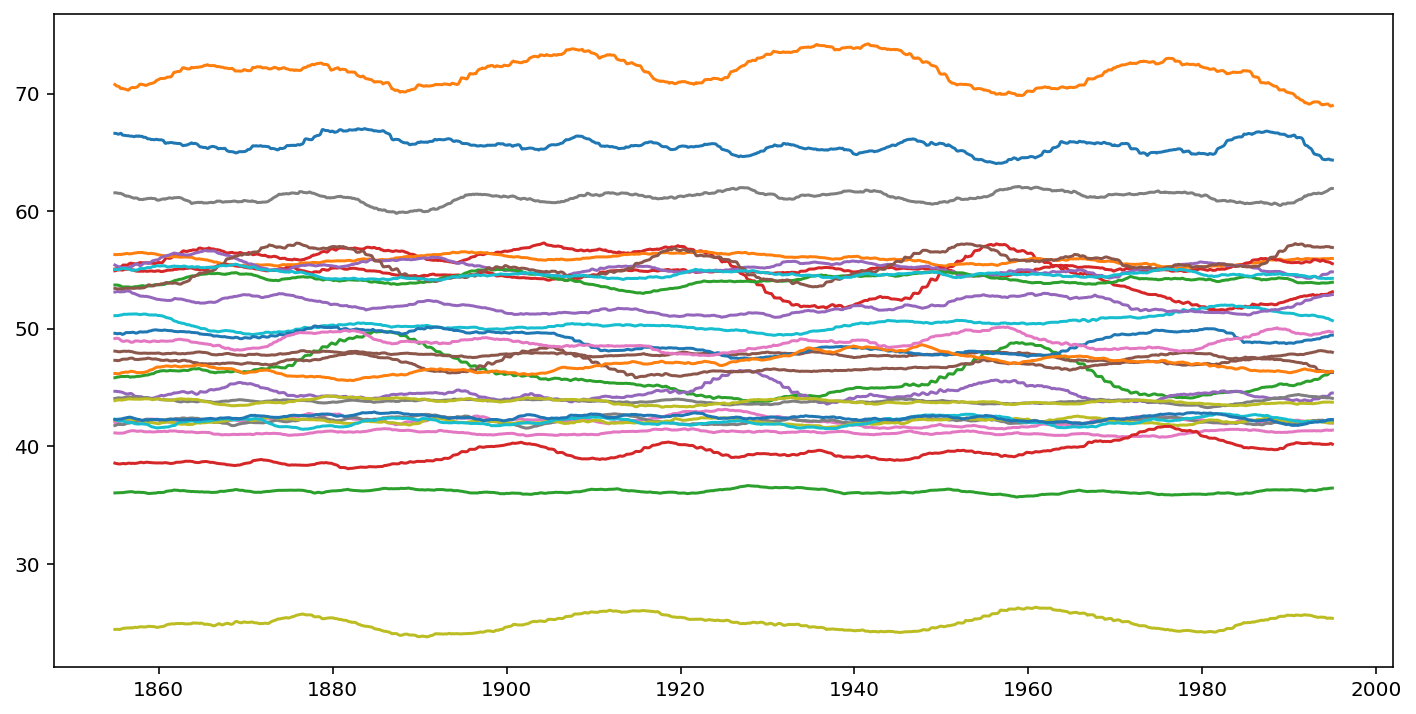

In [10]:
plt.figure('1pctCO2 runs')
plot_time_var(window=10*12, fmt='-', delta=False, experiment_id ='piControl', variable_id='mlotst')

Get all TCRs using $\Delta T$ at $2 \times CO_2$
=========

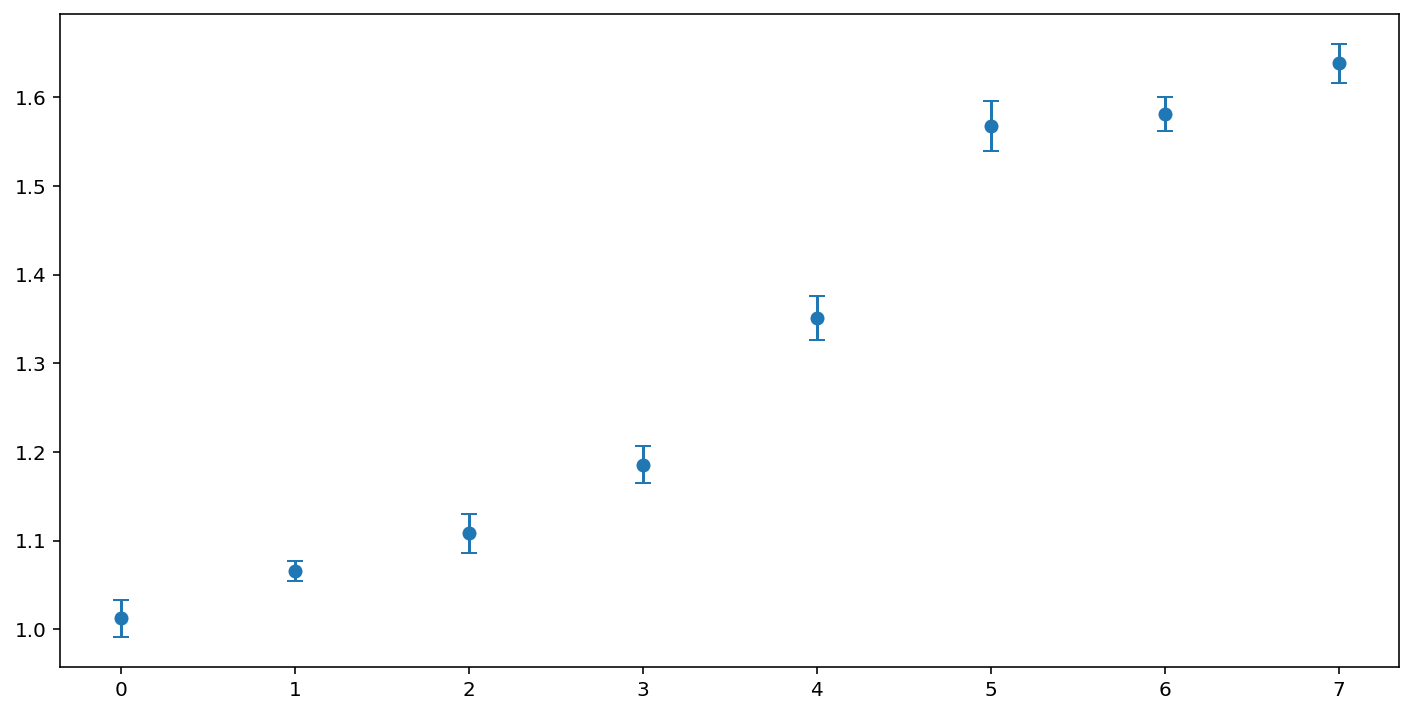

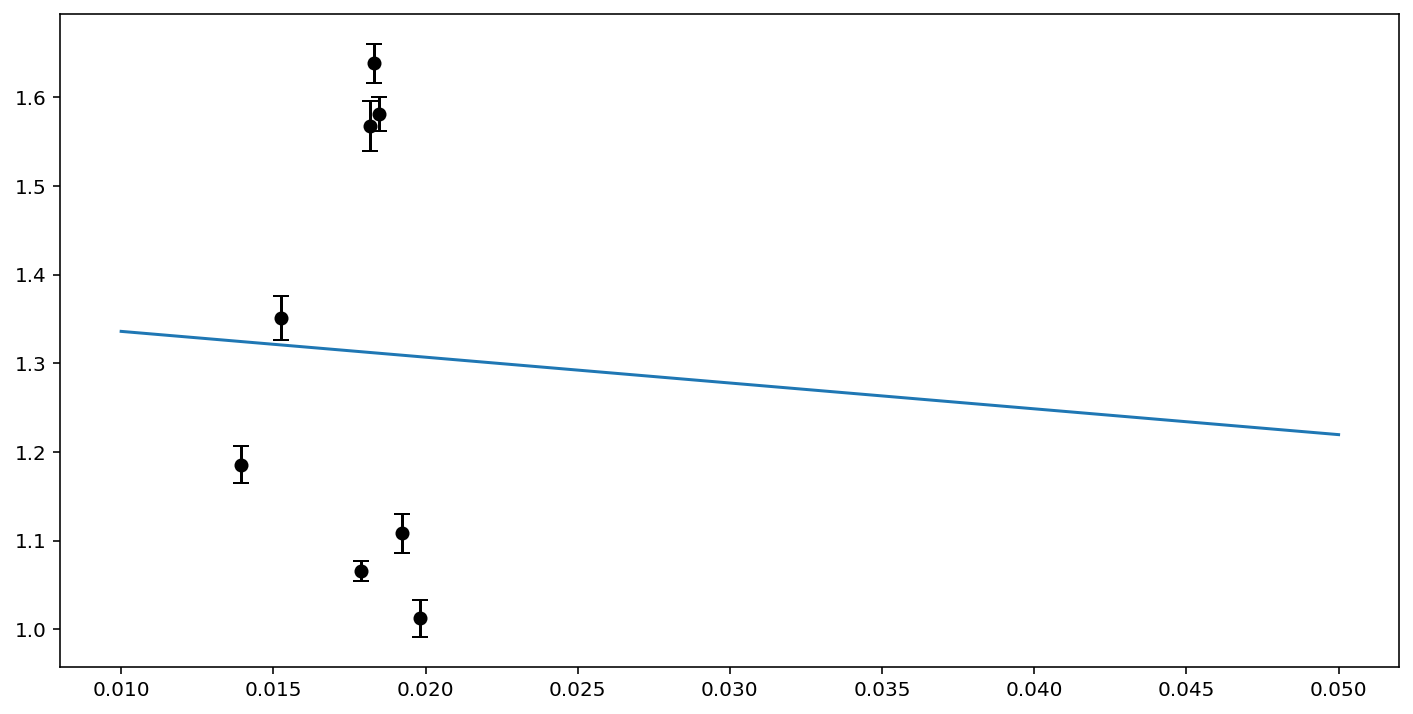

In [82]:
tcrs = []
mlds = []
names = []
var = 'tos'

ts = ensemble_mean('1pctCO2',var)
pi_ts = ensemble_mean('piControl',var)
pi_mlds = ensemble_mean('1pctCO2','mlotst') +
for k in ts.keys() & pi_ts.keys() & pi_mlds.keys():
    pi_t = pi_ts[k]
    t = ts[k]
    
    tcr, err = tcr_classic(t, pi_t)
    
    mld = np.mean(pi_mlds[k])
    mlds += [mld]
    tcrs += [[tcr, err]]
    names += [k]

tcrs = np.array(tcrs)
mlds = np.array(mlds)

vals = zip(mlds, tcrs)
vals = [v for v in vals if v[0] > 26 and v[1][0] > 1]
mlds = np.array(vals)[:,0]
tcrs = np.array([v[1] for v in vals])
srtd = np.array(sorted(tcrs, key = lambda x: x[0]))


plt.figure()
plt.errorbar(x=list(range(len(tcrs))), y=srtd[:,0], yerr=srtd[:,1], fmt='o', capsize=4)
plt.figure()
plt.errorbar(x=1/mlds, y=tcrs[:,0], yerr=tcrs[:,1], fmt='ok', capsize=4)
popt, pcov = curve_fit(linear, 1/mlds, tcrs[:,0])
plt.plot(np.linspace(0.01, 0.05), linear(np.linspace(0.01, 0.05),*popt))

In [78]:
np.linspace(0,0.01)

array([0.        , 0.00020408, 0.00040816, 0.00061224, 0.00081633,
       0.00102041, 0.00122449, 0.00142857, 0.00163265, 0.00183673,
       0.00204082, 0.0022449 , 0.00244898, 0.00265306, 0.00285714,
       0.00306122, 0.00326531, 0.00346939, 0.00367347, 0.00387755,
       0.00408163, 0.00428571, 0.0044898 , 0.00469388, 0.00489796,
       0.00510204, 0.00530612, 0.0055102 , 0.00571429, 0.00591837,
       0.00612245, 0.00632653, 0.00653061, 0.00673469, 0.00693878,
       0.00714286, 0.00734694, 0.00755102, 0.0077551 , 0.00795918,
       0.00816327, 0.00836735, 0.00857143, 0.00877551, 0.00897959,
       0.00918367, 0.00938776, 0.00959184, 0.00979592, 0.01      ])

Compare ECS to average PiControl MLD
======

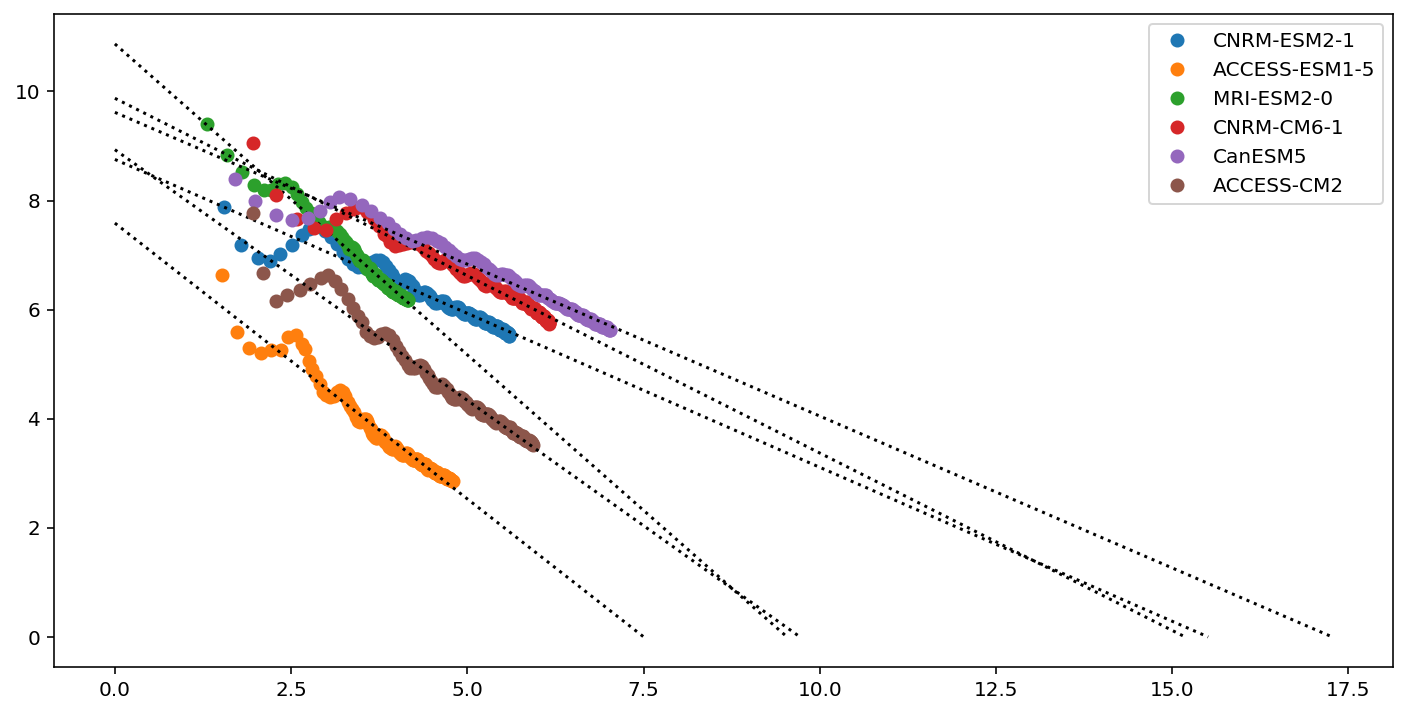

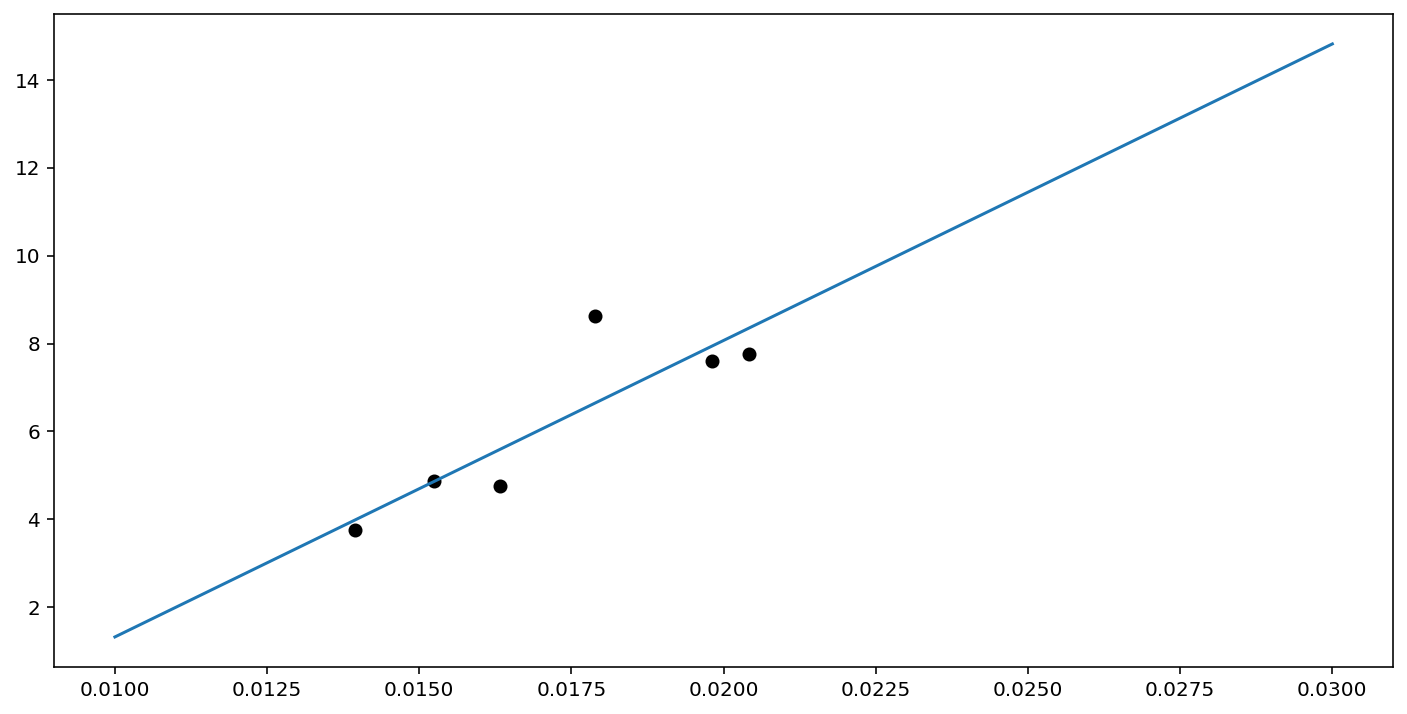

In [92]:
ecss = []
mlds = []
rtmts = []
data = []
var = 'ts'
pi_ts = ensemble_mean('piControl', var)
pi_mlds = ensemble_mean('piControl', 'mlotst')
ts = ensemble_mean('abrupt-4xCO2', var)
Rs = ensemble_mean('abrupt-4xCO2', 'hfds')
for k in pi_ts.keys() & pi_mlds.keys() & ts.keys() & Rs.keys():
    
    t = ts[k]
    pi_t = pi_ts[k]
    R = Rs[k]
    mld = np.mean(pi_mlds[k])
    
    if len(t) < 100*12 or len(R) != len(t) or np.mean(R) < 0:
        continue
    
    minlen = min(len(t),len(pi_t))
    popt, pcov, ecs, toplot = ecs_gregory(t[0:minlen] - pi_t[0:minlen], R[0:minlen])
    
    if ecs < 0:
        continue
    
    ecss += [ecs]
    rtmts += [np.mean(R[0:60])]
    mlds += [mld]
    
    data += [[k, ecs, mld]]
    
#     plt.figure('mld')
#     plt.plot(moving_average(pi_mlds[k], 10*12))
    
    plt.plot(toplot[0], toplot[1], 'o', label=k)
    plt.plot(np.linspace(0,2*ecs), linear(np.linspace(0, 2*ecs),*popt), ':k')
    
    
plt.legend()
df = pd.DataFrame(data)
df.to_csv('abrupt-4x_'+var+'_ranks.csv')

mlds = np.array(mlds)
plt.figure()
plt.plot(1/mlds, ecss, 'ok')
popt, pcov = curve_fit(linear, 1/mlds, ecss)
plt.plot(np.linspace(0.01, 0.03), linear(np.linspace(0.01, 0.03),*popt))

Save data to compare MLDs by models
====

In [68]:
ab = ensemble_mean('abrupt-4xCO2', 'mlotst')
ppy = ensemble_mean('1pctCO2', 'mlotst')
pi = ensemble_mean('piControl','mlotst')
data = []
for k in ab.keys() & ppy.keys() & pi.keys():
    data += [[k, np.mean(pi[k]), np.mean(ppy[k]), np.mean(ab[k])]]
pd.DataFrame(data).to_csv('mlotst-compare.csv')

Plot TCRs against ECSs
=====

failed on  UKESM1-0-LL
600
1800
2.1548110678466035
failed on  HadGEM3-GC31-MM
120
1800
0.3447132125380449
failed on  MPI-ESM1-2-HR
1980
1980
-14.705746325097904
failed on  CESM2
600
2400
0.9499337507955109
failed on  HadGEM3-GC31-LL
600
1800
2.34015778239506
failed on  NorCPM1
960
960
-9.327101012769466
failed on  EC-Earth3-Veg
12
1812
1.4475175966376483


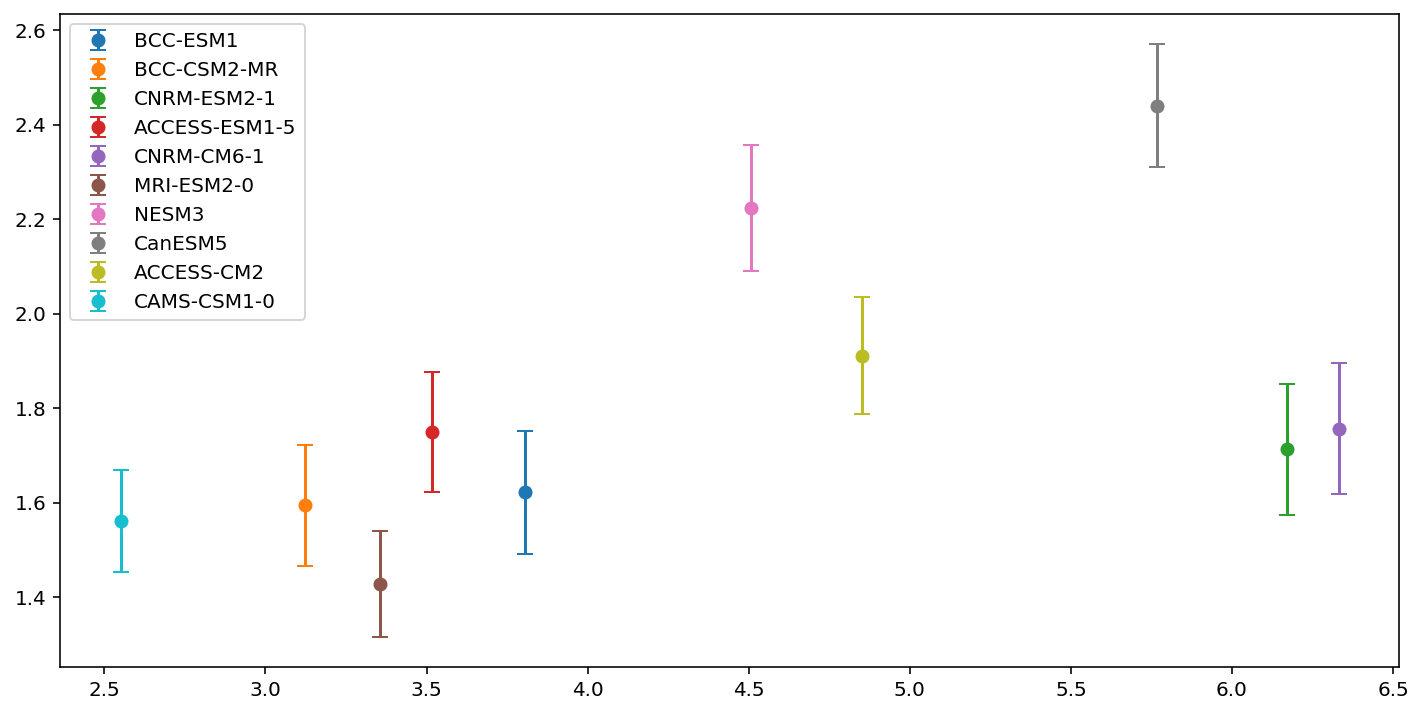

In [29]:
var = 'ts'
pi_ts = ensemble_mean('piControl', var)
p_ts = ensemble_mean('1pctCO2', var)
a_ts = ensemble_mean('abrupt-4xCO2', var)
Rs = ensemble_mean('abrupt-4xCO2', 'rtmt')

ecss = []
tcrs = []
names = []
for k in pi_ts.keys() & p_ts.keys() & Rs.keys():
    pi_t = pi_ts[k]
    p_t = p_ts[k]
    
    tcr, err = tcr_classic(p_t, pi_t)
    
    a_t = a_ts[k]
    R = Rs[k]
    
    if len(a_t) < 100*12 or len(R) != len(a_t) or np.mean(R) < 0:
        print('failed on ',k)
        print(len(R))
        print(len(a_t))
        print(np.mean(R))
        continue
    
    minlen = min(len(a_t),len(pi_t))
    popt, pcov, ecs, toplot = ecs_gregory(a_t[0:minlen] - pi_t[0:minlen], R[0:minlen])
    
    ecss += [ecs]
    tcrs += [[tcr, err]]
    names += [k]
    
    plt.errorbar(ecs, y=tcr, yerr=err, fmt='o', capsize=4, label=k)
    
tcrs = np.array(tcrs)
ecss = np.array(ecss)

plt.legend()

In [ ]:
failed = []

for k in a_ts.keys() & Rs.keys():
    
    a_t = a_ts[k]
    R = Rs[k]
    
    if len(a_t) < 100*12 or len(R) != len(a_t) or np.mean(R) < 0:
        print('failed on ',k)
        print(len(R))
        print(len(a_t))
        print(np.mean(R))
        continue
    failed += [k]
    
for k in a_ts.keys():
    if k not in Rs.keys():
        failed += [k]

Need to get
- gsat, tos, mlotst for missing abrupt-4x CO2 (~20)
- gsat, tos, mlotst for missing 1pctCO2
- rtmt for (1) missing abrupt-4x CO2 and (2) abrupt-4x CO2 without rtmt
- gsat, tos, mlotst for missing piControl

In [46]:
sources = set(dfs.source_id.values)
td = [(f, 'abrupt-4xCO2', 'rtmt') for f in failed]
# Get missing 1pct gsat and tos
ts = ['tos', 'ts', 'mlotst']
ex = ['1pctCO2', 'abrupt-4xCO2', 'piControl']
for t in ts:
    for e in ex:
        ens = ensemble_mean(e, t)
        td += [(s, e, t) for s in sources if s not in ens]
e = '1pctCO2'
t = 'rtmt'
ens = ensemble_mean(e, t)
td += [(s, e, t) for s in sources if s not in ens]

In [47]:
td_1 = [i.split('_') for i in set(['_'.join(j) for j in td])]

In [36]:
a = np.array([r[0:1800] for r in Rs.values() if len(r) >= 1800])

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

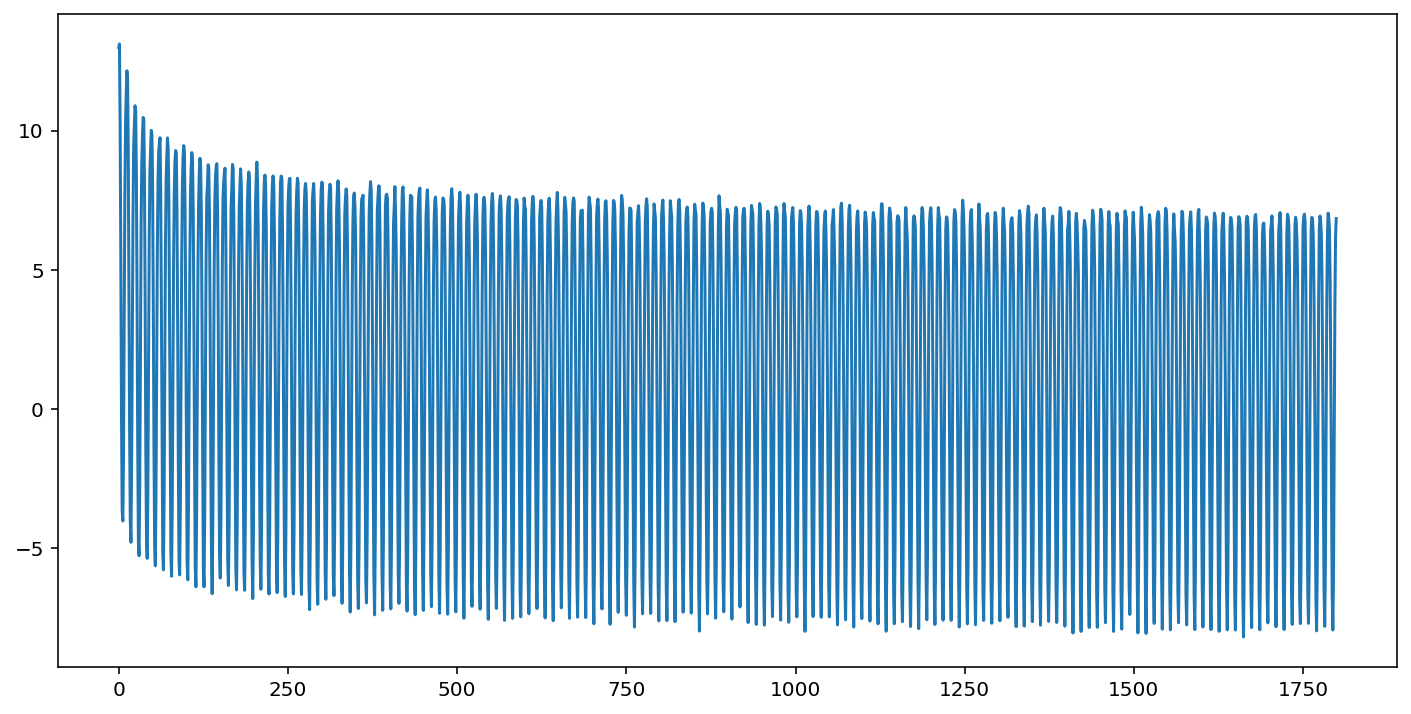

In [45]:
plt.plot(np.average(a, 0))
plt.errorbar(x=range(0,len(a)), y=np.average(a,0), yerr=np.std(a, 0))